# Анализ результатов A/B теста
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

## Импорт библиотек, настройка графиков

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
import time
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
sns.set_theme(
    style='whitegrid',
    font_scale=2,
    palette='dark',
    rc={'figure.figsize': (16, 9)}
)

## Считывание, предварительное изучение и предобработка данных
Считаем файл; удостоверимся, что задание нас не обманывает.

In [3]:
data = pd.read_csv(
    "https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/SOkIsD5A8xlI7Q",
    sep=';'
)

Посмотрим, как выглядят данные.

In [4]:
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Проверка на пропущенные значения в данных:

In [6]:
if data.isnull().sum().sum() == 0:
    print("Пропущенных значений в таблице с данными нет.")
elif data.isnull().sum().sum() > 0:
    print("В таблице с данными есть пропущенные значения.")
else:
    print("С таблицей с данными творится что-то странное.")

Пропущенных значений в таблице с данными нет.


___
Проверим пользователей на уникальность:

In [7]:
data.user_id.nunique() == data.shape[0]

True

___
Проверим значения в столбце testgroup:

In [8]:
data.testgroup.unique()

array(['b', 'a'], dtype=object)

Пользователи делятся на 2 группы: 'a' – контрольная, 'b' – тестовая (как правило, обозначения такие).

___
Посмотрим на размах значений в столбце revenue:

In [9]:
data.revenue.min(), data.revenue.max()

(0, 37433)

Разделим пользователей по группам:

In [10]:
control = data.query("testgroup == 'a'") # Все пользователи контрольной группы.
test = data.query("testgroup == 'b'") # Все пользователи тестовой группы.
print(f"В контрольной группе {control.user_id.nunique()} пользователей.")
print(f"В тестовой группе {test.user_id.nunique()} пользователей.")

В контрольной группе 202103 пользователей.
В тестовой группе 202667 пользователей.


___
Отдельно выделим платящих пользователей:

In [11]:
paying_users_control = control.query("revenue > 0") # Платящие пользователи контрольной группы.
paying_users_test = test.query("revenue > 0") # Платящие пользователи тестовой группы.
print(f"В контрольной группе {paying_users_control.user_id.nunique()} платящих пользователей.")
print(f"В тестовой группе {paying_users_test.user_id.nunique()} платящих пользователей.")

В контрольной группе 1928 платящих пользователей.
В тестовой группе 1805 платящих пользователей.


___
Рассчитаем ARPU и ARPPU:

In [12]:
ARPU_control = control.revenue.sum() / control.user_id.nunique()
ARPU_test = test.revenue.sum() / test.user_id.nunique()
print(f"ARPU контрольной группы {ARPU_control:.2f}.")
print(f"ARPU тестовой группы {ARPU_test:.2f}.")

ARPU контрольной группы 25.41.
ARPU тестовой группы 26.75.


In [13]:
ARPPU_control = paying_users_control.revenue.sum() / paying_users_control.user_id.nunique()
ARPPU_test = paying_users_test.revenue.sum() / paying_users_test.user_id.nunique()
print(f"ARPPU контрольной группы {ARPPU_control:.2f}.")
print(f"ARPPU тестовой группы {ARPPU_test:.2f}.")

ARPPU контрольной группы 2664.00.
ARPPU тестовой группы 3003.66.


___
Также мы можем с имеющимися данными рассчитать конверсию пользователей в клиенты: какой процент от всех пользователей совершает покупки.

In [14]:
conversion_control = paying_users_control.user_id.nunique() / control.user_id.nunique()
conversion_test = paying_users_test.user_id.nunique() / test.user_id.nunique()
print(f"Конверсия пользователей в клиенты в контрольной группе {conversion_control:.2%}.")
print(f"Конверсия пользователей в клиенты в тестовой группе {conversion_test:.2%}.")

Конверсия пользователей в клиенты в контрольной группе 0.95%.
Конверсия пользователей в клиенты в тестовой группе 0.89%.


## Выбор метрик

С имеющимися данными мы можем сравнить контрольную и тестовую группы по следующим метрикам:
- ARPU, как отношение суммарного дохода к числу пользователей.
- ARPPU, как отношение суммарного дохода к числу клиентов (платящих пользователей).
- Конверсии из пользователей в клиенты (отношение числа клиентов к числу пользователей).

Собственно, мы уже посчитали эти показатели в прошлом разделе. Теперь надо определить статистическую значимость полученных различий.

Лучшим будет тот вариант, где эти метрики окажутся статистически значимо выше.

## Сравнение конверсии из пользователей в клиенты

У нас есть 2 категориальных переменных: группа (контроль или тест) и тип пользователя (платящий или неплатящий), причём число наблюдений для каждого варианта сочетаний этих переменных больше 10. Для проверки, зависит ли доля платящих пользователей от группы, используем критерий Хи-квадрат. 

Нулевой гипотезой нашего теста будет предположение, что доля платящих клиентов не зависит от группы. 

Альтернативной гипотезой – доля платящих клиентов зависит от группы. 

Порог для отклонения нулевой гипотезы примем 0.05, т.е. отклоняем нулевую гипотезу при вероятности получения наблюдаемых (или более экстремальных) данных при условии, что нулевая гипотеза верна, (p-value) менее 0.05.

Посчитаем количество платящих и неплатящих пользователей в группах, сформируем таблицу сопряжённости и применим критерий Хи-квадрат

In [15]:
payers_number_test = paying_users_test.user_id.nunique()
payers_number_control = paying_users_control.user_id.nunique()
non_payers_number_test = test.user_id.nunique() - paying_users_test.user_id.nunique()
non_payers_number_control = control.user_id.nunique() - paying_users_control.user_id.nunique()

cont_table = [
    [payers_number_test, non_payers_number_test], # платящие/неплатящие в тестовой группе
    [payers_number_control, non_payers_number_control] # платящие/неплатящие в контрольной группе
]

stat, p_val, dof, expected = ss.chi2_contingency(cont_table)
if p_val <= 0.05:
    print(f'''P-value: {p_val:.3f}. Отклоняем нулевую гипотезу, принимаем альтернативную.
    
Доля платящих клиентов (и, как следствие, конверсия) зависит от группы.''')
    if conversion_control > conversion_test:
        print("Конверсия из пользователей в клиенты статистически значимо выше в контрольной группе.")
    elif conversion_control < conversion_test:
        print("Конверсия из пользователей в клиенты статистически значимо выше в тестовой группе.")
else:
    print(f'P-value: {p_val:.3f}. Не можем отклонить нулевую гипотезу.')

P-value: 0.036. Отклоняем нулевую гипотезу, принимаем альтернативную.
    
Доля платящих клиентов (и, как следствие, конверсия) зависит от группы.
Конверсия из пользователей в клиенты статистически значимо выше в контрольной группе.


## Сравнение ARPU

Для сравнения ARPU мы должны сравнить средние двух выборок: control.revenue и test.revenue. Уже понятно (по числу неплатящих пользователей), что большинство значений в этих выборках нули. Соответственно, распределение очень далеко от нормального. Попробуем его визуализировать.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


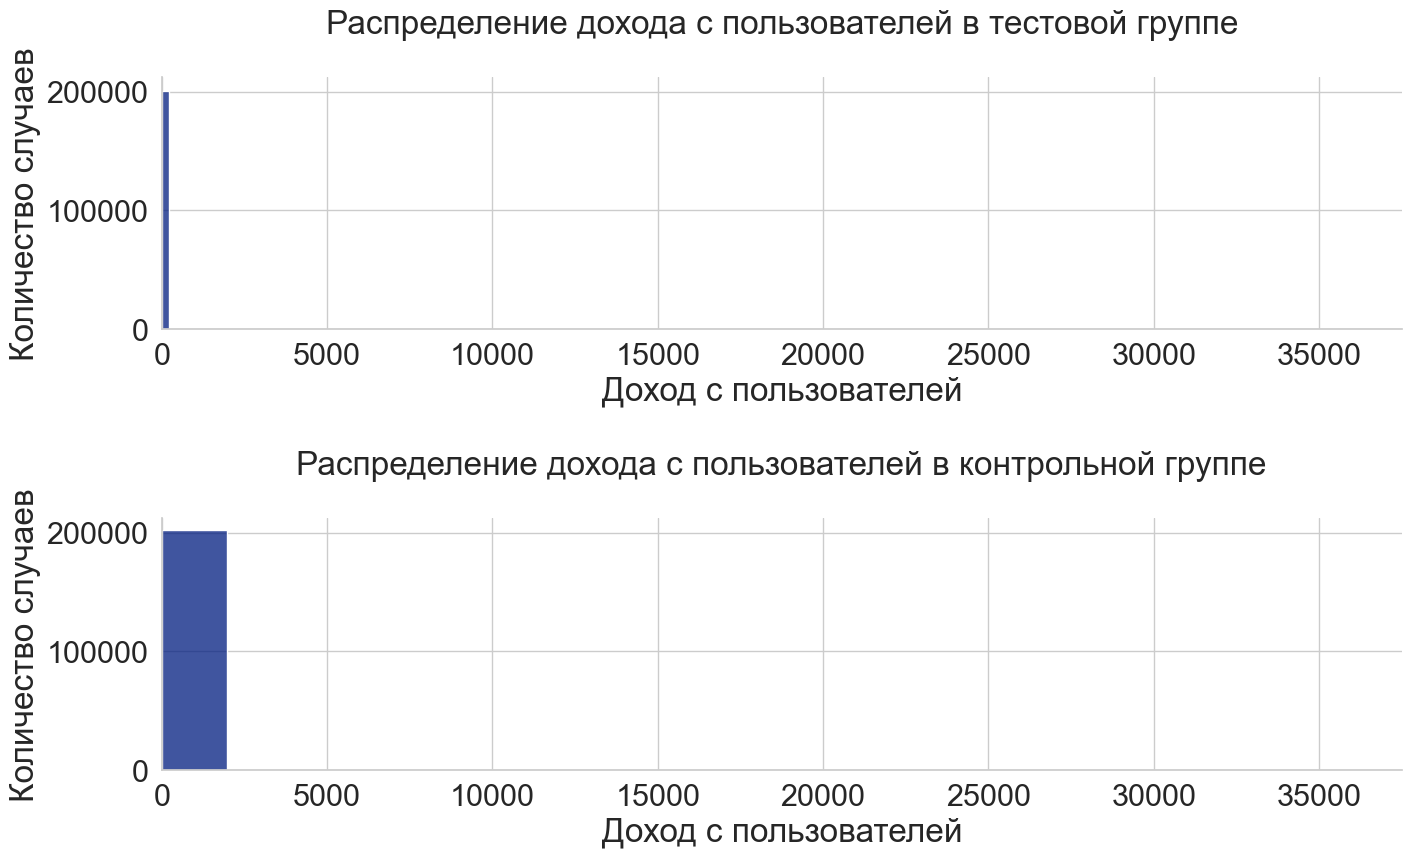

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharey=True)

sns.histplot(test.revenue, ax=axs[0])
axs[0].set_title('Распределение дохода с пользователей в тестовой группе\n')
axs[0].set_xlabel('Доход с пользователей')
axs[0].set_ylabel('Количество случаев')
axs[0].set_xlim(0, 37500) # Устанавливаем границы графика по размаху значений столбца revenue.

sns.histplot(control.revenue, ax=axs[1])
axs[1].set_title('Распределение дохода с пользователей в контрольной группе\n')
axs[1].set_xlabel('Доход с пользователей')
axs[1].set_ylabel('Количество случаев')
axs[1].set_xlim(0, 37500) # Устанавливаем границы графика по размаху значений столбца revenue.

fig.subplots_adjust(hspace=0.75)

sns.despine()

Нулей так много, что графики неинформативны. Попробуем построить распределение только ненулевых значений.

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


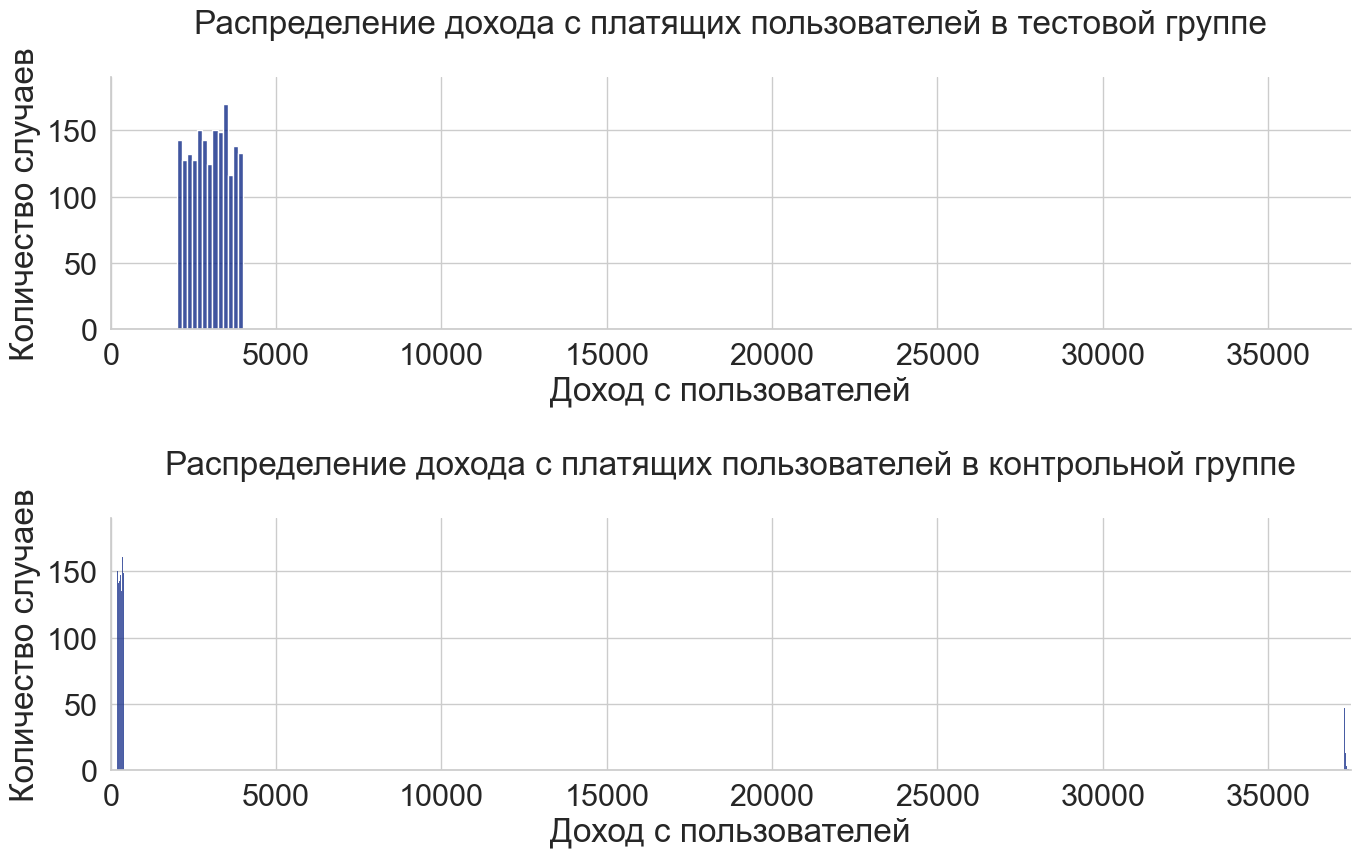

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharey=True)

sns.histplot(test.revenue[test.revenue > 0], ax=axs[0])
axs[0].set_title('Распределение дохода с платящих пользователей в тестовой группе\n')
axs[0].set_xlabel('Доход с пользователей')
axs[0].set_ylabel('Количество случаев')
axs[0].set_xlim(0, 37500) # Устанавливаем границы графика по размаху значений столбца revenue.

sns.histplot(control.revenue[control.revenue > 0], ax=axs[1])
axs[1].set_title('Распределение дохода с платящих пользователей в контрольной группе\n')
axs[1].set_xlabel('Доход с пользователей')
axs[1].set_ylabel('Количество случаев')
axs[1].set_xlim(0, 37500) # Устанавливаем границы графика по размаху значений столбца revenue.

fig.subplots_adjust(hspace=0.75)

sns.despine()

Дополним визуализацию боксплотом и виолинплотом.

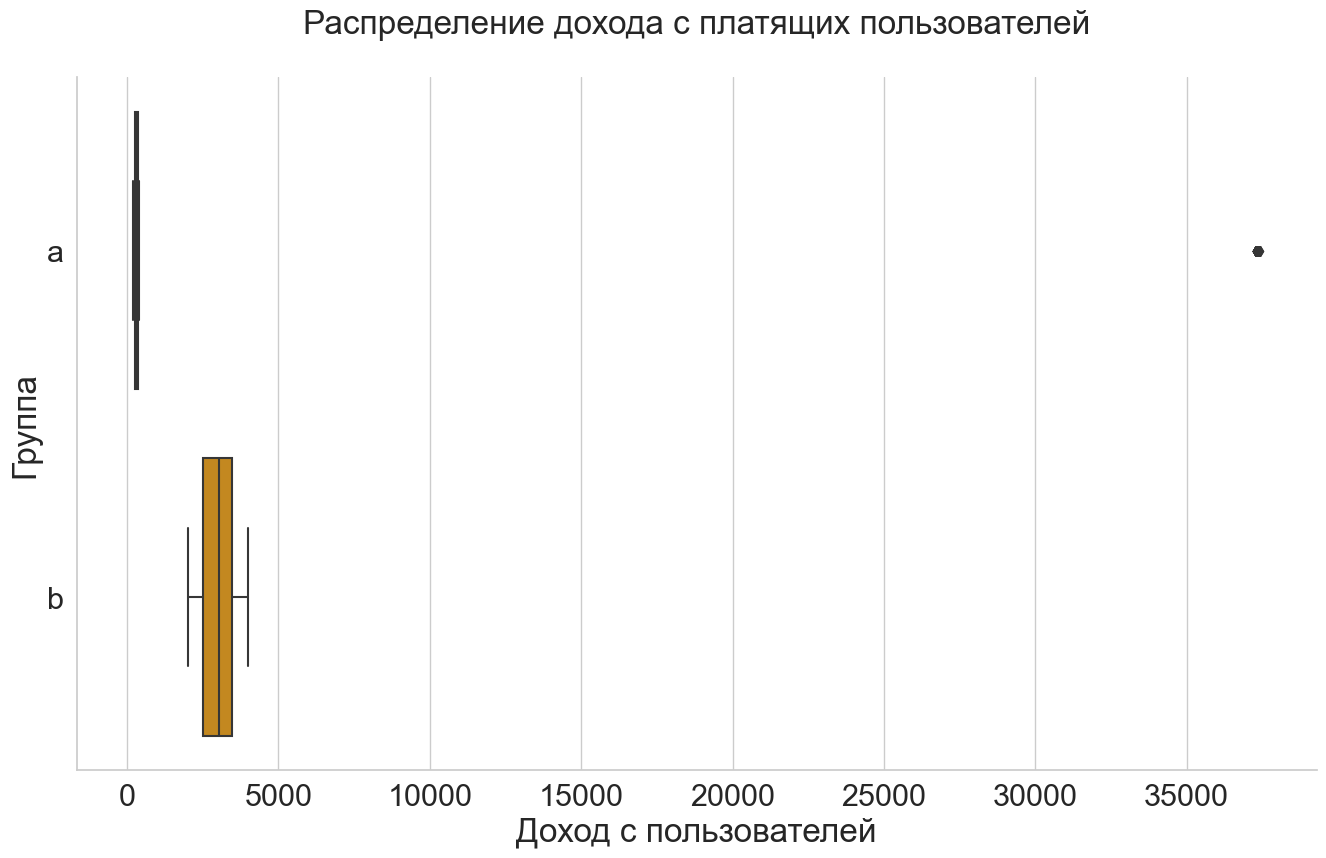

In [18]:
axs = sns.boxplot(data=data[data.revenue > 0], x='revenue', y='testgroup', palette='colorblind')
axs.set_title('Распределение дохода с платящих пользователей\n')
axs.set_xlabel('Доход с пользователей')
axs.set_ylabel('Группа')
sns.despine()

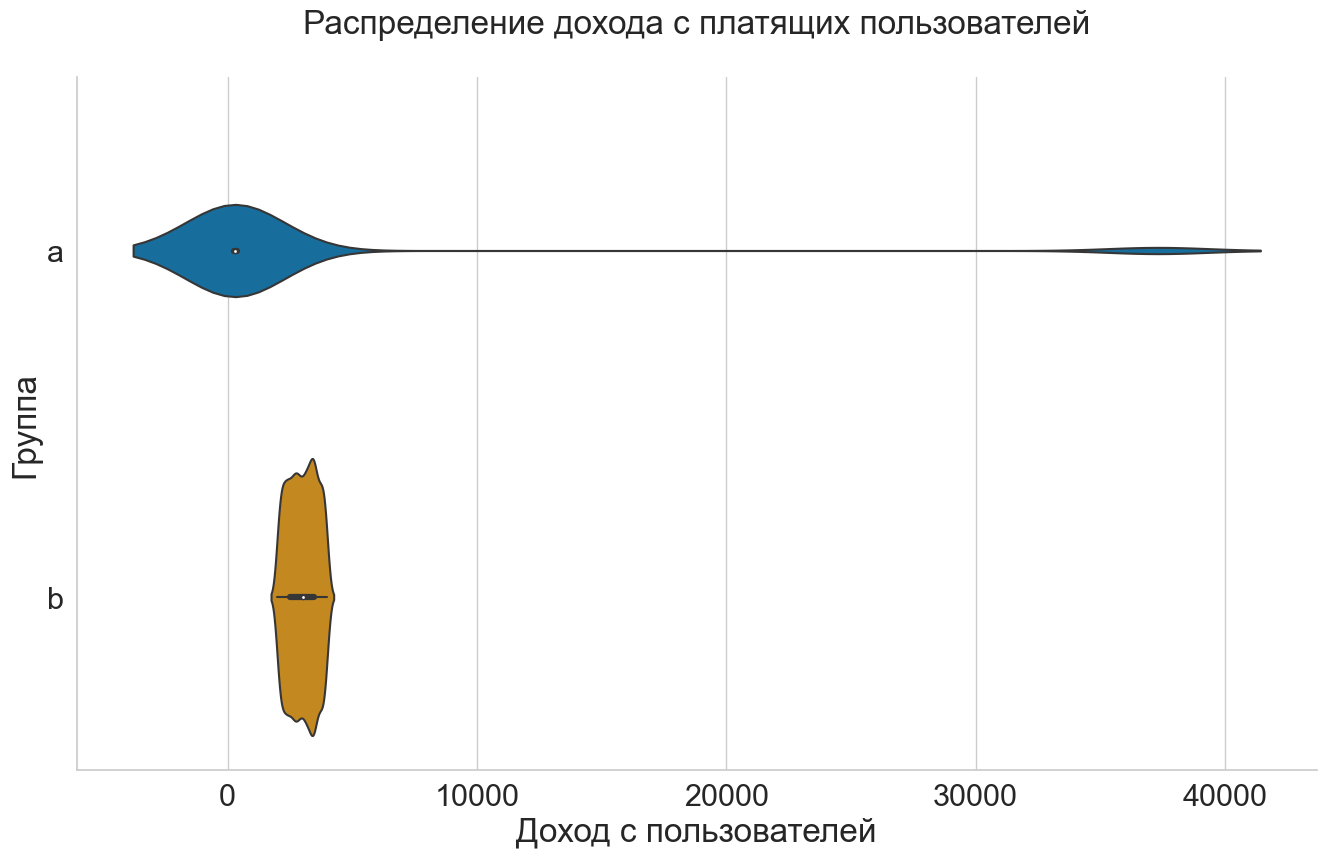

In [19]:
axs = sns.violinplot(data=data[data.revenue > 0], x='revenue', y='testgroup', palette='colorblind')
axs.set_title('Распределение дохода с платящих пользователей\n')
axs.set_xlabel('Доход с пользователей')
axs.set_ylabel('Группа')
sns.despine()

Ситуация немного прояснилась. Видно, что в тестовой группе значения распределены более-менее равномерно на среднем уровне. В контрольной же есть два ярко выраженных кластера: платящие очень мало и платящие очень много. И не забываем, что большинство значений в обоих выборках – нули.

___
Я считаю, что для сравнения ARPU при таких ненормально распределённых данных нам следует использовать бутстрап. Из наших выборок мы возьмём по 10000 подвыборок такого же размера (с повторениями) и получим распределение их средних. Определим 95%-ные доверительные интервалы (ДИ) этих распределений (взяв 2.5%-ный и 97.5%-ный квантили) и посмотрим, насколько они перекрываются. Оценить p-value по пересечению доверительных интервалов можно по рекомендациям [статьи](https://www.researchgate.net/publication/7994369_Inference_by_Eye_Confidence_Intervals_and_How_to_Read_Pictures_of_Data).

Нулевой гипотезой будет предположение, что выборки взяты из одной генеральной совокупности, и их средние на самом деле равны.

Альтернативной – что это не так.

Брать сразу 10000 подвыборок тяжело, не хватает машинных ресурсов. Поэтому будем брать 20 раз по 500 выборок, а потом соединим результаты. Разницы быть не должно. Замерим время выполнения всей процедуры.

In [20]:
start_time = time.time()

means_array = np.array([]) # Пустой массив, куда добавляем средние подвыборок.

for i in range(20):
    result = pg.compute_bootci(
        x=test.revenue, 
        func='mean', 
        n_boot=500, 
        return_dist=True
    )
    means_array = np.append(means_array, result[1])
    
test_ci_low = np.percentile(means_array, 2.5) # Нижняя граница 95% ДИ.
test_ci_high = np.percentile(means_array, 97.5) # Верхняя граница 95% ДИ.
test_mean = np.mean(means_array) # Среднее, полученное в результате бутстрапирования

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.2f} сек.")
print(f'''
Верхняя граница 95% ДИ для ARPU тестовой группы {test_ci_high:.2f}.
Нижняя граница 95% ДИ для ARPU тестовой группы {test_ci_low:.2f}. 

Бутстрапированное ARPU тестовой группы {test_mean:.2f}. 
''')

Время выполнения: 26.56 сек.

Верхняя граница 95% ДИ для ARPU тестовой группы 28.00.
Нижняя граница 95% ДИ для ARPU тестовой группы 25.48. 

Бутстрапированное ARPU тестовой группы 26.75. 



In [21]:
start_time = time.time()

means_array = np.array([]) # Пустой массив, куда добавляем средние подвыборок.

for i in range(20):
    result = pg.compute_bootci(
        x=control.revenue, 
        func='mean', 
        n_boot=500, 
        return_dist=True
    )
    means_array = np.append(means_array, result[1])
    
control_ci_low = np.percentile(means_array, 2.5) # Нижняя граница 95% ДИ.
control_ci_high = np.percentile(means_array, 97.5) # Верхняя граница 95% ДИ.
control_mean = np.mean(means_array) # Среднее, полученное в результате бутстрапирования

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.2f} сек.")
print(f'''
Верхняя граница 95% ДИ для ARPU контрольной группы {control_ci_high:.2f}.
Нижняя граница 95% ДИ для ARPU контрольной группы {control_ci_low:.2f}. 

Бутстрапированное ARPU контрольной группы {control_mean:.2f}. 
''')

Время выполнения: 27.23 сек.

Верхняя граница 95% ДИ для ARPU контрольной группы 29.42.
Нижняя граница 95% ДИ для ARPU контрольной группы 21.57. 

Бутстрапированное ARPU контрольной группы 25.39. 



___
Визуализируем результат.

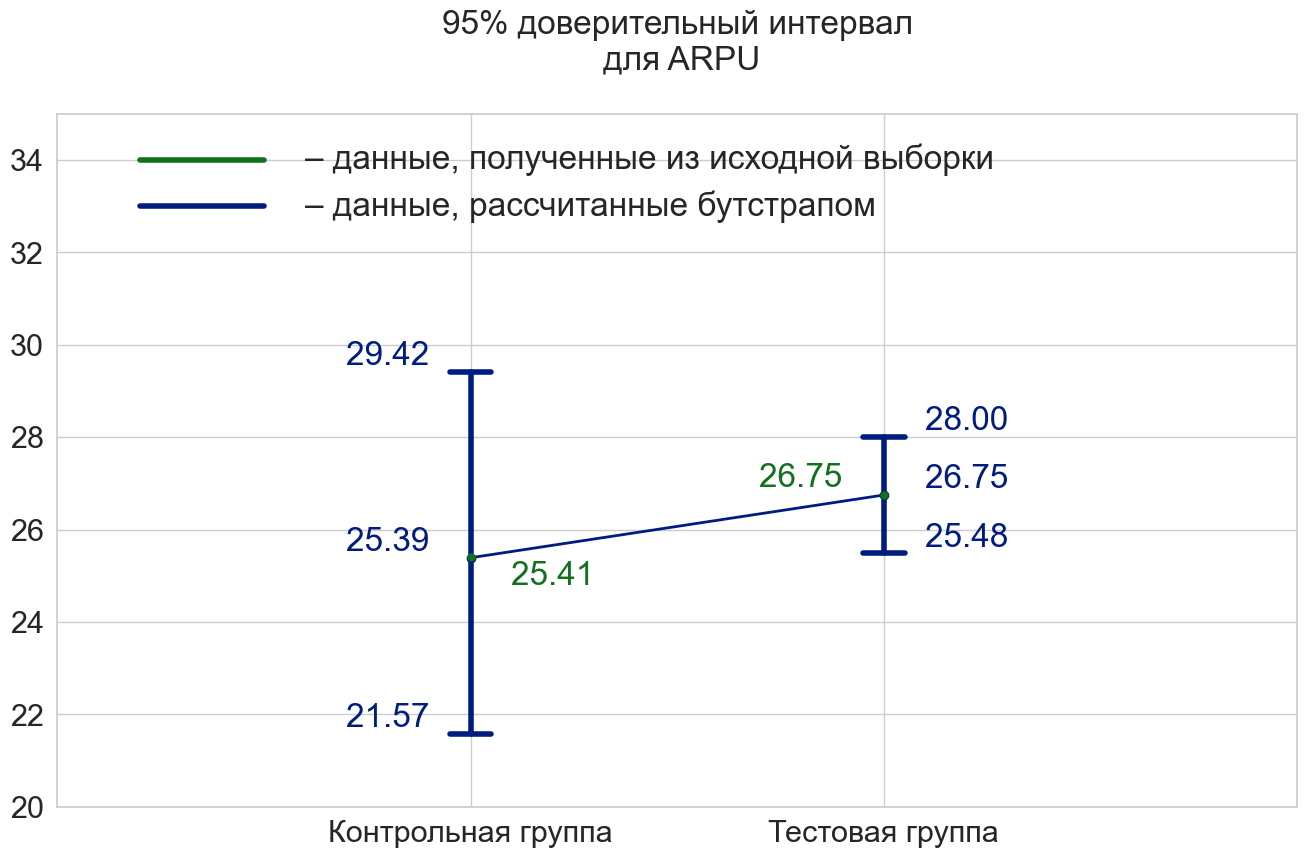

<Figure size 1600x900 with 0 Axes>

In [22]:
# Установим границы графика.
plt.xlim(0, 3)
plt.ylim(
    round(min(control_ci_low, test_ci_low), -1), 
    round(max(control_ci_high, test_ci_high), -1)+5
)

# Нарисуем доверительные интервалы.
plt.plot([1, 1], [control_ci_low, control_ci_high], color='b', linewidth=4)
plt.plot([2, 2], [test_ci_low, test_ci_high], color='b', linewidth=4)
plt.plot([1, 2], [control_mean , test_mean ], color='b',  marker='o', linewidth=2)
plt.plot([1-0.05, 1+0.05], [control_ci_high, control_ci_high], color='b', linewidth=4)
plt.plot([1-0.05, 1+0.05], [control_ci_low, control_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [test_ci_low, test_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [test_ci_high, test_ci_high], color='b', linewidth=4)

# Отметим точками ARPU, полученные из исходной выборки.
plt.plot(1, ARPU_control, color='g',  marker='o', markersize=5)
plt.plot(2, ARPU_test, color='g',  marker='o', markersize=5)

# Подпишем все значения.
plt.text(1-0.1, control_ci_low, f'{control_ci_low:.2f}', ha='right', va='bottom', color='b')
plt.text(1-0.1, control_ci_high, f'{control_ci_high:.2f}', ha='right', va='bottom', color='b')
plt.text(2+0.1, test_ci_low,  f'{test_ci_low:.2f}', ha='left', va='bottom', color='b')
plt.text(2+0.1, test_ci_high,  f'{test_ci_high:.2f}', ha='left', va='bottom', color='b')
plt.text(2+0.1, test_mean,  f'{test_mean:.2f}', ha='left', va='bottom', color='b')
plt.text(1-0.1, control_mean,  f'{control_mean:.2f}', ha='right', va='bottom', color='b')
plt.text(1+0.3, ARPU_control-0.1,  f'{ARPU_control:.2f}', ha='right', va='top', color='g')
plt.text(2-0.1, ARPU_test+0.7,  f'{ARPU_test:.2f}', ha='right', va='top', color='g')

# Нарисуем легенду.
plt.plot(
    [0.2, 0.5], 
    [round(max(control_ci_high, test_ci_high), -1)+4, round(max(control_ci_high, test_ci_high), -1)+4],
    color='g', 
    linewidth=4
)
plt.plot(
    [0.2, 0.5], 
    [round(max(control_ci_high, test_ci_high), -1)+3, round(max(control_ci_high, test_ci_high), -1)+3],
    color='b', 
    linewidth=4
)
plt.text(
    0.6, 
    round(max(control_ci_high, test_ci_high), -1)+4, 
    "– данные, полученные из исходной выборки", 
    ha='left', 
    va='center')
plt.text(
    0.6, 
    round(max(control_ci_high, test_ci_high), -1)+3, 
    "– данные, рассчитанные бутстрапом", 
    ha='left', 
    va='center')

# Подписи тиков.
plt.xticks([1, 2], ["Контрольная группа", "Тестовая группа"])

# Заголовок.
plt.title("95% доверительный интервал\n для ARPU\n")

plt.show()
sns.despine()

Доверительные интервалы бутстрапированных ARPU контрольной и тестовой групп значительно пересекаются (ДИ тестовой группы полностью лежит внутри ДИ контрольной группы).

В такой ситуации мы не можем отклонить нулевую гипотезу и говорить о статистически значимых различиях между ними.

## Сравнение ARPPU

В прошлом разделе мы уже визуализировали распределение дохода с платящих пользователей. Проблемы тут те же: крайне ненормальное распределение. 

Так же применим бутстрап. Из выборок paying_users_control.revenue и paying_users_test.revenue возьмём по 10000 подвыборок такого же размера (с повторениями) и получим распределение их средних. Определим 95%-ные доверительные интервалы (ДИ) этих распределений (взяв 2.5%-ный и 97.5%-ный квантили) и посмотрим, насколько они перекрываются. Оценить p-value по пересечению доверительных интервалов можно по рекомендациям [статьи](https://www.researchgate.net/publication/7994369_Inference_by_Eye_Confidence_Intervals_and_How_to_Read_Pictures_of_Data).

Нулевой гипотезой будет предположение, что выборки взяты из одной генеральной совокупности, и их средние на самом деле равны.

Альтернативной – что это не так.

Брать сразу 10000 подвыборок тяжело, не хватает машинных ресурсов. Поэтому будем брать 20 раз по 500 выборок, а потом соединим результаты. Разницы быть не должно. Замерим время выполнения всей процедуры.

In [23]:
start_time = time.time()

means_array = np.array([]) # Пустой массив, куда добавляем средние подвыборок.

for i in range(20):
    result = pg.compute_bootci(
        x=paying_users_test.revenue, 
        func='mean', 
        n_boot=500, 
        return_dist=True
    )
    means_array = np.append(means_array, result[1])
    
test_paying_ci_low = np.percentile(means_array, 2.5) # Нижняя граница 95% ДИ.
test_paying_ci_high = np.percentile(means_array, 97.5) # Верхняя граница 95% ДИ.
test_paying_mean = np.mean(means_array) # Среднее, полученное в результате бутстрапирования

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.2f} сек.")
print(f'''
Верхняя граница 95% ДИ для ARPPU тестовой группы {test_paying_ci_high:.2f}.
Нижняя граница 95% ДИ для ARPPU тестовой группы {test_paying_ci_low:.2f}. 

Бутстрапированное ARPPU тестовой группы {test_paying_mean:.2f}. 
''')

Время выполнения: 0.27 сек.

Верхняя граница 95% ДИ для ARPPU тестовой группы 3029.83.
Нижняя граница 95% ДИ для ARPPU тестовой группы 2976.91. 

Бутстрапированное ARPPU тестовой группы 3003.51. 



In [24]:
start_time = time.time()

means_array = np.array([]) # Пустой массив, куда добавляем средние подвыборок.

for i in range(20):
    result = pg.compute_bootci(
        x=paying_users_control.revenue, 
        func='mean', 
        n_boot=500, 
        return_dist=True
    )
    means_array = np.append(means_array, result[1])
    
control_paying_ci_low = np.percentile(means_array, 2.5) # Нижняя граница 95% ДИ.
control_paying_ci_high = np.percentile(means_array, 97.5) # Верхняя граница 95% ДИ.
control_paying_mean = np.mean(means_array) # Среднее, полученное в результате бутстрапирования

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.2f} сек.")
print(f'''
Верхняя граница 95% ДИ для ARPPU контрольной группы {control_paying_ci_high:.2f}.
Нижняя граница 95% ДИ для ARPPU контрольной группы {control_paying_ci_low:.2f}. 

Бутстрапированное ARPPU контрольной группы {control_paying_mean:.2f}. 
''')

Время выполнения: 0.29 сек.

Верхняя граница 95% ДИ для ARPPU контрольной группы 3083.79.
Нижняя граница 95% ДИ для ARPPU контрольной группы 2261.23. 

Бутстрапированное ARPPU контрольной группы 2663.78. 



___
Визуализируем результат.

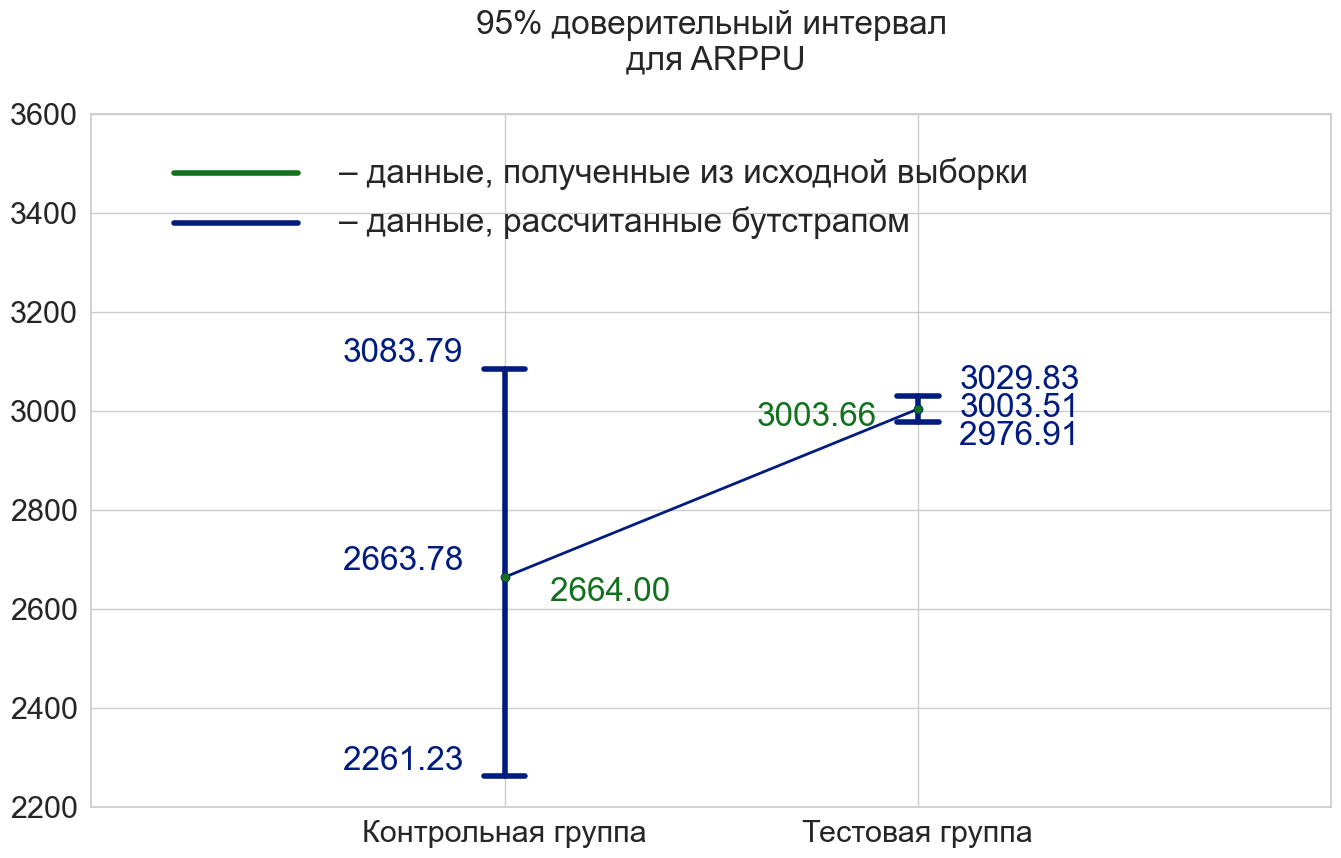

<Figure size 1600x900 with 0 Axes>

In [25]:
# Установим границы графика.
plt.xlim(0, 3)
plt.ylim(
    round(min(control_paying_ci_low, test_paying_ci_low), -2)-100, 
    round(max(control_paying_ci_high, test_paying_ci_high), -2)+500
)

# Нарисуем доверительные интервалы.
plt.plot([1, 1], [control_paying_ci_low, control_paying_ci_high], color='b', linewidth=4)
plt.plot([2, 2], [test_paying_ci_low, test_paying_ci_high], color='b', linewidth=4)
plt.plot([1, 2], [control_paying_mean , test_paying_mean ], color='b',  marker='o', linewidth=2)
plt.plot([1-0.05, 1+0.05], [control_paying_ci_high, control_paying_ci_high], color='b', linewidth=4)
plt.plot([1-0.05, 1+0.05], [control_paying_ci_low, control_paying_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [test_paying_ci_low, test_paying_ci_low], color='b', linewidth=4)
plt.plot([2-0.05, 2+0.05], [test_paying_ci_high, test_paying_ci_high], color='b', linewidth=4)

# Отметим точками ARPPU, полученные из исходной выборки.
plt.plot(1, ARPPU_control, color='g',  marker='o', markersize=5)
plt.plot(2, ARPPU_test, color='g',  marker='o', markersize=5)

# Подпишем все значения.
plt.text(1-0.1, control_paying_ci_low, f'{control_paying_ci_low:.2f}', ha='right', va='bottom', color='b')
plt.text(1-0.1, control_paying_ci_high, f'{control_paying_ci_high:.2f}', ha='right', va='bottom', color='b')
plt.text(2+0.1, test_paying_ci_low-60,  f'{test_paying_ci_low:.2f}', ha='left', va='bottom', color='b')
plt.text(2+0.1, test_paying_ci_high,  f'{test_paying_ci_high:.2f}', ha='left', va='bottom', color='b')
plt.text(2+0.1, test_paying_mean-30,  f'{test_paying_mean:.2f}', ha='left', va='bottom', color='b')
plt.text(1-0.1, control_paying_mean,  f'{control_paying_mean:.2f}', ha='right', va='bottom', color='b')
plt.text(1+0.4, ARPPU_control,  f'{ARPPU_control:.2f}', ha='right', va='top', color='g')
plt.text(2-0.1, ARPPU_test+15,  f'{ARPPU_test:.2f}', ha='right', va='top', color='g')

# Нарисуем легенду.
plt.plot(
    [0.2, 0.5], 
    [
        round(max(control_paying_ci_high, test_paying_ci_high), -1)+400, 
        round(max(control_paying_ci_high, test_paying_ci_high), -1)+400
    ],
    color='g', 
    linewidth=4
)
plt.plot(
    [0.2, 0.5], 
    [
        round(max(control_paying_ci_high, test_paying_ci_high), -1)+300, 
        round(max(control_paying_ci_high, test_paying_ci_high), -1)+300
    ],
    color='b', 
    linewidth=4
)
plt.text(
    0.6, 
    round(max(control_paying_ci_high, test_paying_ci_high), -1)+400, 
    "– данные, полученные из исходной выборки", 
    ha='left', 
    va='center')
plt.text(
    0.6, 
    round(max(control_paying_ci_high, test_paying_ci_high), -1)+300, 
    "– данные, рассчитанные бутстрапом", 
    ha='left', 
    va='center')

# Подписи тиков.
plt.xticks([1, 2], ["Контрольная группа", "Тестовая группа"])

# Заголовок.
plt.title("95% доверительный интервал\n для ARPPU\n")

plt.show()
sns.despine()

Доверительные интервалы бутстрапированных ARPPU контрольной и тестовой групп значительно пересекаются (ДИ тестовой группы полностью лежит внутри ДИ контрольной группы).

В такой ситуации мы не можем отклонить нулевую гипотезу и говорить о статистически значимых различиях между ними.

## Выводы, рекомендации

Применение критерия Хи-квадрат показало, что конверсия из пользователей в клиенты статистически значимо снизилась в тестовой группе.

При этом определение с помощью бутстрапа доверительных интервалов для ARPU и ARPPU не показало статистически значимых различий.

Таким образом, слегка лучшим является набор акционных предложений в контрольной группе. Одна из метрик (пусть и не главная) при нём лучше, а 2 основные – такие же.

При этом наблюдается следующая картина: в контрольной группе клиенты делятся на малоплатящих и сверхплатящих, а в тестовой все среднеплатящие. Если нам удастся создать новый вариант акционных предложений, который сохранит сверхплатящих клиентов, но при этом переведёт малоплатящих в среднеплатящие (как случилось в тестовой группе в нашем эксперименте), основные метрики могут вырасти.